<a href="https://colab.research.google.com/github/elham1996/Word2Vec/blob/main/doc2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import,division,print_function
import codecs#encoding,word embedding
import glob#find all filenames matching a pattern
import logging#log events for libraries
import multiprocessing#concurrency
import os#dealing with operating system like reading file
import pprint#pretty print, human readable
import re#regular expression
import nltk#natural language toolkit
import gensim.models.word2vec as w2v#word2vec
import sklearn.manifold#dimensionality reduction
import numpy as np#math
import matplotlib.pyplot#plotting
import pandas as pd#parse dataset
import seaborn as sns#visualization
from sklearn.decomposition import PCA
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize


In [2]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [3]:
#process our data
#clean data
#stopwords like the at a an, unnecesasry
#tokenization into sentences, punkt 
#http://www.nltk.org/
nltk.download("punkt")#pretrained tokenizer
nltk.download("stopwords")#words like,and,the,an,of,a

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
#get the paper names,matching text files
doc_filenames = sorted(glob.glob("/content/Data/*.txt"))
doc_filenames

['/content/Data/document_10.txt',
 '/content/Data/document_11.txt',
 '/content/Data/document_12.txt',
 '/content/Data/document_13.txt',
 '/content/Data/document_14.txt',
 '/content/Data/document_15.txt',
 '/content/Data/document_16.txt',
 '/content/Data/document_17.txt',
 '/content/Data/document_18.txt',
 '/content/Data/document_19.txt',
 '/content/Data/document_2.txt',
 '/content/Data/document_20.txt',
 '/content/Data/document_3.txt',
 '/content/Data/document_4.txt',
 '/content/Data/document_5.txt',
 '/content/Data/document_6.txt',
 '/content/Data/document_7.txt',
 '/content/Data/document_8.txt',
 '/content/Data/document_9.txt']

In [8]:
#step 1 process data
#initialize rawunicode , we'll add all text to a big file in memory
corpus_raw = u""
#for each book, read it, open it un utf 8 format, 
#add it to the raw corpus
for doc in doc_filenames:
    print("Reading '{0}'...".format(doc))
    with codecs.open(doc, "r", "utf-8") as docs:
        corpus_raw += docs.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading '/content/Data/document_10.txt'...
Corpus is now 1741 characters long

Reading '/content/Data/document_11.txt'...
Corpus is now 13660 characters long

Reading '/content/Data/document_12.txt'...
Corpus is now 20698 characters long

Reading '/content/Data/document_13.txt'...
Corpus is now 23470 characters long

Reading '/content/Data/document_14.txt'...
Corpus is now 31624 characters long

Reading '/content/Data/document_15.txt'...
Corpus is now 63077 characters long

Reading '/content/Data/document_16.txt'...
Corpus is now 73148 characters long

Reading '/content/Data/document_17.txt'...
Corpus is now 79973 characters long

Reading '/content/Data/document_18.txt'...
Corpus is now 82098 characters long

Reading '/content/Data/document_19.txt'...
Corpus is now 177040 characters long

Reading '/content/Data/document_2.txt'...
Corpus is now 194769 characters long

Reading '/content/Data/document_20.txt'...
Corpus is now 285904 characters long

Reading '/content/Data/document_3.txt'.

In [9]:
#tokenizastion! saved the trained model here
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [10]:
#tokenize into sentences
raw_sentences = tokenizer.tokenize(corpus_raw)

In [11]:
#convert into list of words
#remove unecessary characters, split into words, no hyhens and shit
#split into words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [12]:
#for each sentece, sentences where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [13]:
#print an example
print(raw_sentences[3])
print(sentence_to_wordlist(raw_sentences[5]))

QS Enterprises Ltd now operates across two divisions: Queen Square Private Healthcare which works in partnership with The National Hospital for Neurology and Neurosurgery in Queen Square, London, and the Chenies Mews Imaging Centre, a dedicated clinical and research cardiac Magnetic Resonance Scanner (MRI) facility on Chenies Mews, Central London[2]

History[edit]
QS Enterprises Ltd was formed on 24 September 1984[1] in order to fund the first MRI scanner for the National Hospital for Neurology and Neurosurgery in Queen Square.
['Following', 'the', 'creation', 'of', 'the', 'UCLH', 'NHS', 'Trust', 'in', 'QS', 'Enterprises', 'joined', 'forces', 'with', 'the', 'UCLH', 'Charity', 'working', 'as', 'the', 'United', 'Kingdom', 's', 'first', 'health', 'sector', 'social', 'enterprise']


In [14]:
#count tokens, each one being a sentence
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 73,263 tokens


In [15]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [16]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [17]:
thrones2vec.build_vocab(sentences)

2021-11-06 10:24:49,128 : INFO : collecting all words and their counts
2021-11-06 10:24:49,130 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-11-06 10:24:49,159 : INFO : collected 11359 word types from a corpus of 73263 raw words and 3199 sentences
2021-11-06 10:24:49,161 : INFO : Loading a fresh vocabulary
2021-11-06 10:24:49,264 : INFO : effective_min_count=3 retains 3823 unique words (33% of original 11359, drops 7536)
2021-11-06 10:24:49,265 : INFO : effective_min_count=3 leaves 63800 word corpus (87% of original 73263, drops 9463)
2021-11-06 10:24:49,283 : INFO : deleting the raw counts dictionary of 11359 items
2021-11-06 10:24:49,285 : INFO : sample=0.001 downsamples 37 most-common words
2021-11-06 10:24:49,290 : INFO : downsampling leaves estimated 47856 word corpus (75.0% of prior 63800)
2021-11-06 10:24:49,305 : INFO : estimated required memory for 3823 words and 300 dimensions: 11086700 bytes
2021-11-06 10:24:49,309 : INFO : resetting layer w

In [18]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 3823


In [19]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count , epochs=100)

2021-11-06 10:25:08,049 : INFO : training model with 2 workers on 3823 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2021-11-06 10:25:08,467 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-06 10:25:08,520 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-06 10:25:08,522 : INFO : EPOCH - 1 : training on 73263 raw words (47815 effective words) took 0.5s, 104106 effective words/s
2021-11-06 10:25:08,944 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-06 10:25:08,998 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-06 10:25:09,000 : INFO : EPOCH - 2 : training on 73263 raw words (47942 effective words) took 0.5s, 102288 effective words/s
2021-11-06 10:25:09,423 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-11-06 10:25:09,458 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-11-06 10:25:09,459 : INFO : EPOCH 

(4786664, 7326300)

In [20]:
#save model
if not os.path.exists(os.path.join("trained",'sample')):
    os.makedirs(os.path.join("trained",'sample'))

In [21]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2021-11-06 10:25:57,122 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2021-11-06 10:25:57,126 : INFO : not storing attribute vectors_norm
2021-11-06 10:25:57,130 : INFO : not storing attribute cum_table
2021-11-06 10:25:57,243 : INFO : saved trained/thrones2vec.w2v


In [22]:
#load model
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2021-11-06 10:26:13,643 : INFO : loading Word2Vec object from trained/thrones2vec.w2v
2021-11-06 10:26:13,736 : INFO : loading wv recursively from trained/thrones2vec.w2v.wv.* with mmap=None
2021-11-06 10:26:13,738 : INFO : setting ignored attribute vectors_norm to None
2021-11-06 10:26:13,741 : INFO : loading vocabulary recursively from trained/thrones2vec.w2v.vocabulary.* with mmap=None
2021-11-06 10:26:13,743 : INFO : loading trainables recursively from trained/thrones2vec.w2v.trainables.* with mmap=None
2021-11-06 10:26:13,746 : INFO : setting ignored attribute cum_table to None
2021-11-06 10:26:13,748 : INFO : loaded trained/thrones2vec.w2v


In [23]:
#squash dimensionality to 2,,t-SNE is a tool for data visualization
from sklearn.preprocessing import StandardScaler
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [24]:
#put it all into a big matrix
all_word_vectors_matrix = thrones2vec.wv.vectors

In [25]:
#train t sne
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [26]:
#plot point in 2d space
points = pd.DataFrame(
    [ 
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [27]:
points.head(1000)

,word,x,y
0,QS,-23.281115,25.232203
1,Enterprises,-23.320431,25.250465
2,Ltd,-23.453808,25.307230
3,From,-24.552422,47.910664
4,Wikipedia,-24.676220,48.183498
...,...,...,...
995,adequate,25.522812,-18.446062
996,activity,25.550060,-20.386713
997,loss,38.639790,-1.202202
998,sufficient,-1.780198,-42.378742


In [28]:
#plot
sns.set_context("poster")

In [29]:
points.tail(1000)

,word,x,y
2823,MLK,-28.034367,6.840488
2824,Leadership,-45.580673,27.585989
2825,Ralph,-44.370758,26.224773
2826,Abernathy,-44.389721,26.215700
2827,Atlanta,-25.700245,6.679538
...,...,...,...
3818,San,-18.024677,18.098194
3819,portraits,-18.280235,19.441601
3820,poet,-18.245499,19.474558
3821,Vigo,-18.239641,19.465906


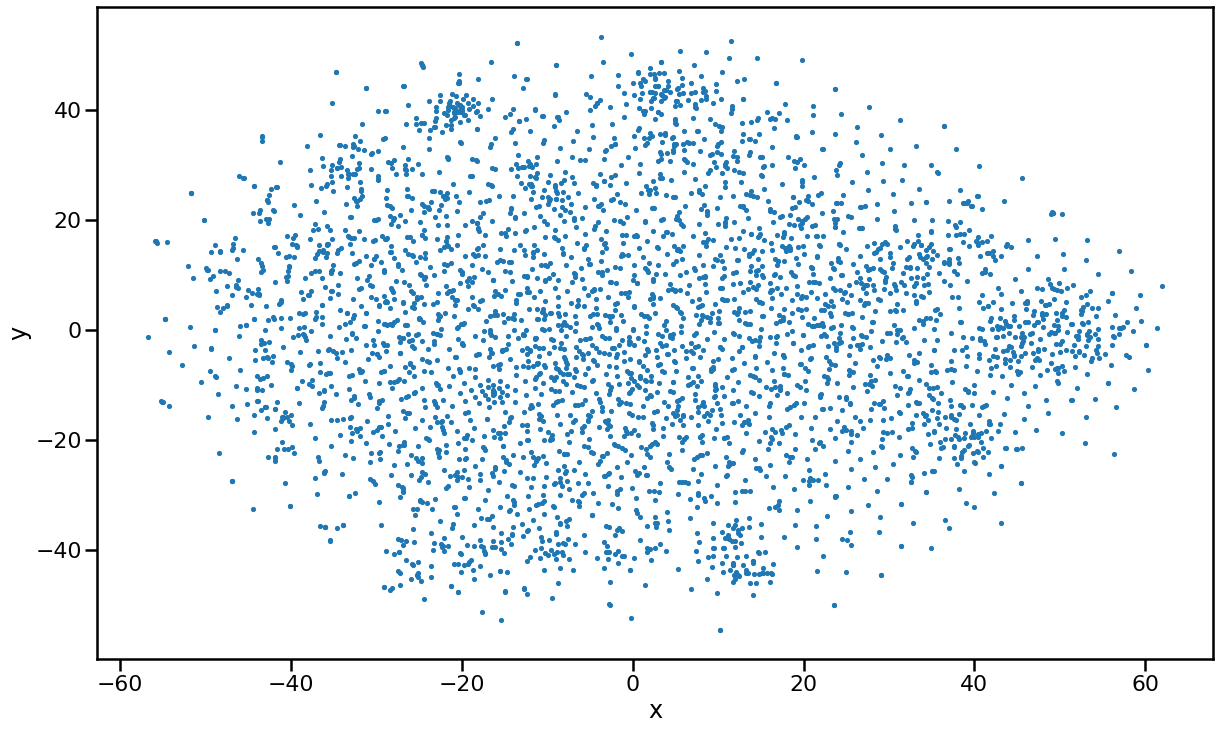

In [30]:
ax=points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [31]:
#distance,similarity and ranking
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

2021-11-06 10:28:40,203 : INFO : NumExpr defaulting to 2 threads.


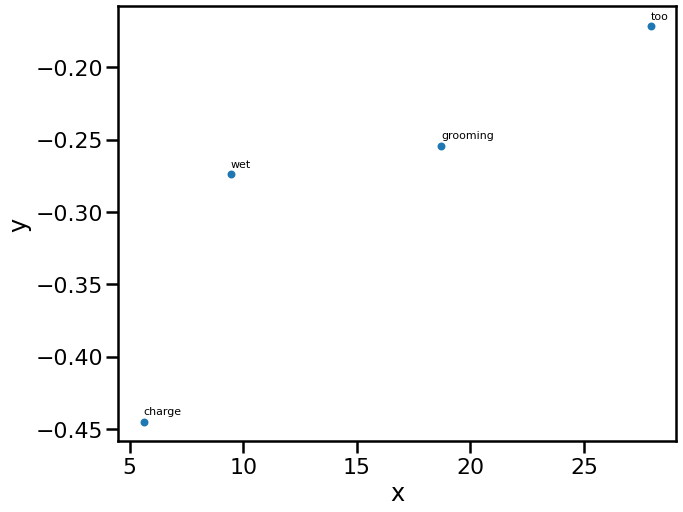

In [32]:
plot_region(x_bounds=(4, 30), y_bounds=(-0.5, -0.1))

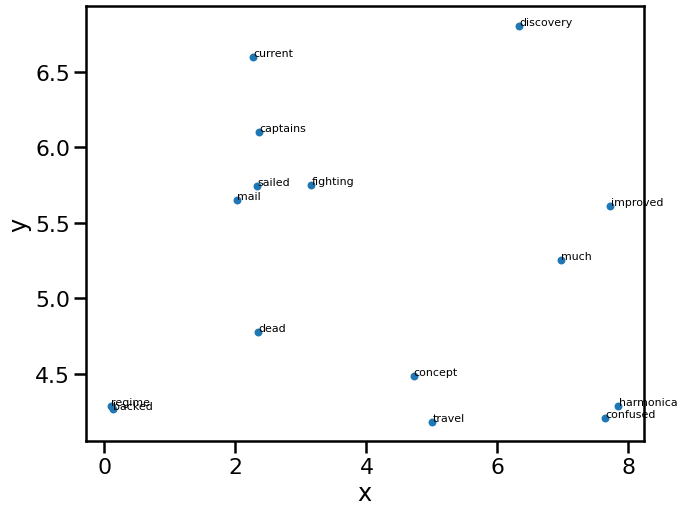

In [33]:
plot_region(x_bounds=(0, 8), y_bounds=(4, 7))

In [35]:
thrones2vec.wv.most_similar("thousand")

[('acres', 0.6435402631759644),
 ('purchase', 0.6179470419883728),
 ('fair', 0.5750135183334351),
 ('copies', 0.5512736439704895),
 ('sold', 0.5173351168632507),
 ('fiction', 0.515659511089325),
 ('surrounding', 0.48535239696502686),
 ('develop', 0.48385089635849),
 ('ten', 0.48117581009864807),
 ('biggest', 0.4807230532169342)]

In [36]:
thrones2vec.wv.most_similar("88")

KeyError: ignored

In [40]:
thrones2vec.wv.most_similar("people")

[('promised', 0.38114210963249207),
 ('admired', 0.3700217604637146),
 ('gradually', 0.3562178313732147),
 ('residential', 0.3554510474205017),
 ('purchase', 0.35376307368278503),
 ('tonight', 0.351540207862854),
 ('oppressed', 0.34878110885620117),
 ('developing', 0.346981942653656),
 ('organizing', 0.3439165949821472),
 ('ill', 0.3423253297805786)]

In [38]:
thrones2vec.wv.most_similar("tennis")

KeyError: ignored

In [39]:
thrones2vec.wv.most_similar("match")

KeyError: ignored

In [41]:
thrones2vec.wv.most_similar("the")


[('of', 0.34052032232284546),
 ('Bulleen', 0.26128876209259033),
 ('testified', 0.2521178722381592),
 ('controversial', 0.2492714524269104),
 ('deviates', 0.24443835020065308),
 ('Yale', 0.2422420233488083),
 ('Fame', 0.24033313989639282),
 ('Andrews', 0.2398793250322342),
 ('elected', 0.23979638516902924),
 ('ignored', 0.23940959572792053)]

In [42]:
thrones2vec.wv.most_similar("plastic")

KeyError: ignored

In [43]:
 thrones2vec.wv.most_similar("container") 

KeyError: ignored

In [44]:
 thrones2vec.wv.most_similar("see") 

[('disambiguation', 0.4796372056007385),
 ('Regiment', 0.4416317939758301),
 ('frac', 0.4393131732940674),
 ('imperative', 0.4316873848438263),
 ('Busy', 0.4204476475715637),
 ('reciprocals', 0.39886951446533203),
 ('huge', 0.38826417922973633),
 ('sixth', 0.3841361999511719),
 ('Mahalia', 0.38058483600616455),
 ('Chaos', 0.37728631496429443)]

In [51]:
thrones2vec.wv.most_similar("img") 

KeyError: ignored

In [50]:
thrones2vec.wv.most_similar("src") 

KeyError: ignored

In [47]:
 thrones2vec.wv.most_similar("drawing.jpg") 

KeyError: ignored

In [49]:
 thrones2vec.wv.most_similar("alt") 

KeyError: ignored

In [54]:

! pip freeze -r req.txt

## The following requirements were added by pip freeze:
absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argcomplete==1.12.3
argon2-cffi==21.1.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.5.30
cffi==1.14.6
cftime==1.5.1
chardet==3.0.4
charset-normalizer==2.0.7
clang==5.0
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.24
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
def

In [52]:
points.to_csv("/content/final.csv")
